# Noncooperative Games with Prospect Theoretic Preferences

In [1]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(123)

## Parameters

In [2]:
n = 20
a_v = torch.tensor(data=[359.84, 360.39, 360.27, 376.49, 361.83, 371.01, 371.47, 361.47, 394.52, 383.71, 375.75, 394.13,
                         373.33, 396.22, 366.85, 385.26, 361.07, 364.02, 386.64, 361.69], requires_grad=False, dtype=torch.float32)
b_v = 0.5
bi_v = torch.tensor(data=[1.2e3,  1.2e3, 1.499e3, 1.116e3, 1.0394e3, 1.43864e3, 1.3588e3, 1.35899e3, .80848e3, 1.4185e3,
                          .7454e3, 1.079e3, 1.364466e3, 1.13779e3, 1.8925e3, 1.08761e3, 2.84512e3, .988795e3, .67218e3, .928609e3],
                    requires_grad=False, dtype=torch.float32)
y_v = torch.tensor(data=[35, 40, 32, 24, 31, 44, 36, 41, 37, 29, 32, 42, 50, 40, 33, 37, 41, 31, 24, 30], dtype=torch.float32)
# d^0
x_0 = torch.mean(y_v)
# \xi
xi_v = torch.tensor(data=np.sort(np.random.gumbel(loc=.2, scale=0.2, size=500)), requires_grad=False, dtype=torch.float32)
# P_bar
P_OH_v = 15.8

The tariff is split into two parts: a fixed fee $\bar{P} > 0$ defined as a constant, during the first part of the day, and a variable charge defined during the second part of the day $P(\xi) = \bar{P} + c + \xi$ where c > 0 is a constant offset as the peak electricity price and $\xi$ is a $\mu$-mean fluctuation arbitrarily distributed over a set of $K$ atoms and such that $\xi_1 < \ldots < \xi_K$ and $p_k = P[{\xi = \xi_k}]$, $\forall k = 1, \ldots, K$.

In [3]:
# peak electricity prices
def P_PH(P_OH, xi, b=b_v):
    val = P_OH + b + xi
    return val

Moreover, to encourage the end users to take into account the social aspects of their energy consumption, the supplier imposes a penalty for deviations from a collective target. We let $y^0 = \frac{1}{N}\sum_{i=1}^{N} yi$ be the community collective target, and $\sigma(x)= \frac{1}{N}\sum_{i=1}^{N}x_i$ be the aggregate purchase. In this setting, end user i’s profit function takes the form:

$$ 
f_i(\boldsymbol{x}_i,\sigma(\boldsymbol{x}),\xi) = U_i(\sigma(\boldsymbol{x})) - C_i(\boldsymbol{x}_i,\xi)
$$

## EUT

In [4]:
# function to ensure that variables remain strictly positive
def projection(x,epsilon=1e-6):
    return torch.clamp(x, min=epsilon)

# objective_function
def obj_fun_eut(i, x, x_i, P_OH_val=P_OH_v, b_val=b_v, xi_val=xi_v, y=y_v, x0=x_0, a=a_v, b=bi_v):
    N = len(x_i)
    a_i = a[i]
    b_i = b[i]
    y_i = y[i]
    indices = [j for j in range(N) if j != i]
    x_neg_i = x_i[indices]
    sn = torch.sum(x_neg_i)
    U_i = - a_i * ((x + sn) / N - x0) ** 2 + b_i
    C_i = P_OH_val * x + P_PH(xi=xi_val, P_OH=P_OH_val, b=b_val) * (y_i - x)
    #res = U_i - C_i
    res = torch.mean(U_i - C_i)
    return res

# optim_eut N_agents=n
def optim_eut(N_agents:int):
    # optim params
    num_iterations = 30
    #tolerance = 1e-6
    learning_rate = 0.01
    #
    x_values = np.array((num_iterations+1) * [np.repeat(a=np.nan, repeats=N_agents)])
    for iteration in range(num_iterations+1):
        if iteration == 0:
            x_values[iteration, :] = np.repeat(a=1., repeats=N_agents)
        for i in range(N_agents):
            if iteration == 0:
                x_i_copy = torch.tensor(x_values[iteration, i].item(), requires_grad=True)
                loss = obj_fun_eut(x=x_i_copy, x_i=torch.tensor(x_values[iteration, :]), i=i)
                loss.backward()
                x_new = projection(x_values[iteration, i].item() + learning_rate * x_i_copy.grad)
                x_values[iteration, i] = x_new
            else:
                x_i_copy = torch.tensor(x_values[iteration-1, i].item(), requires_grad=True)
                loss = obj_fun_eut(x=x_i_copy, x_i=torch.tensor(x_values[iteration-1, :]), i=i)
                loss.backward()
                x_new = projection(x_values[iteration-1 , i].item() + learning_rate * x_i_copy.grad)
                x_values[iteration, i] = x_new
    #
    res = x_values
    return res


In [5]:
# execution EUT
all_sol_eut = optim_eut(N_agents=n)

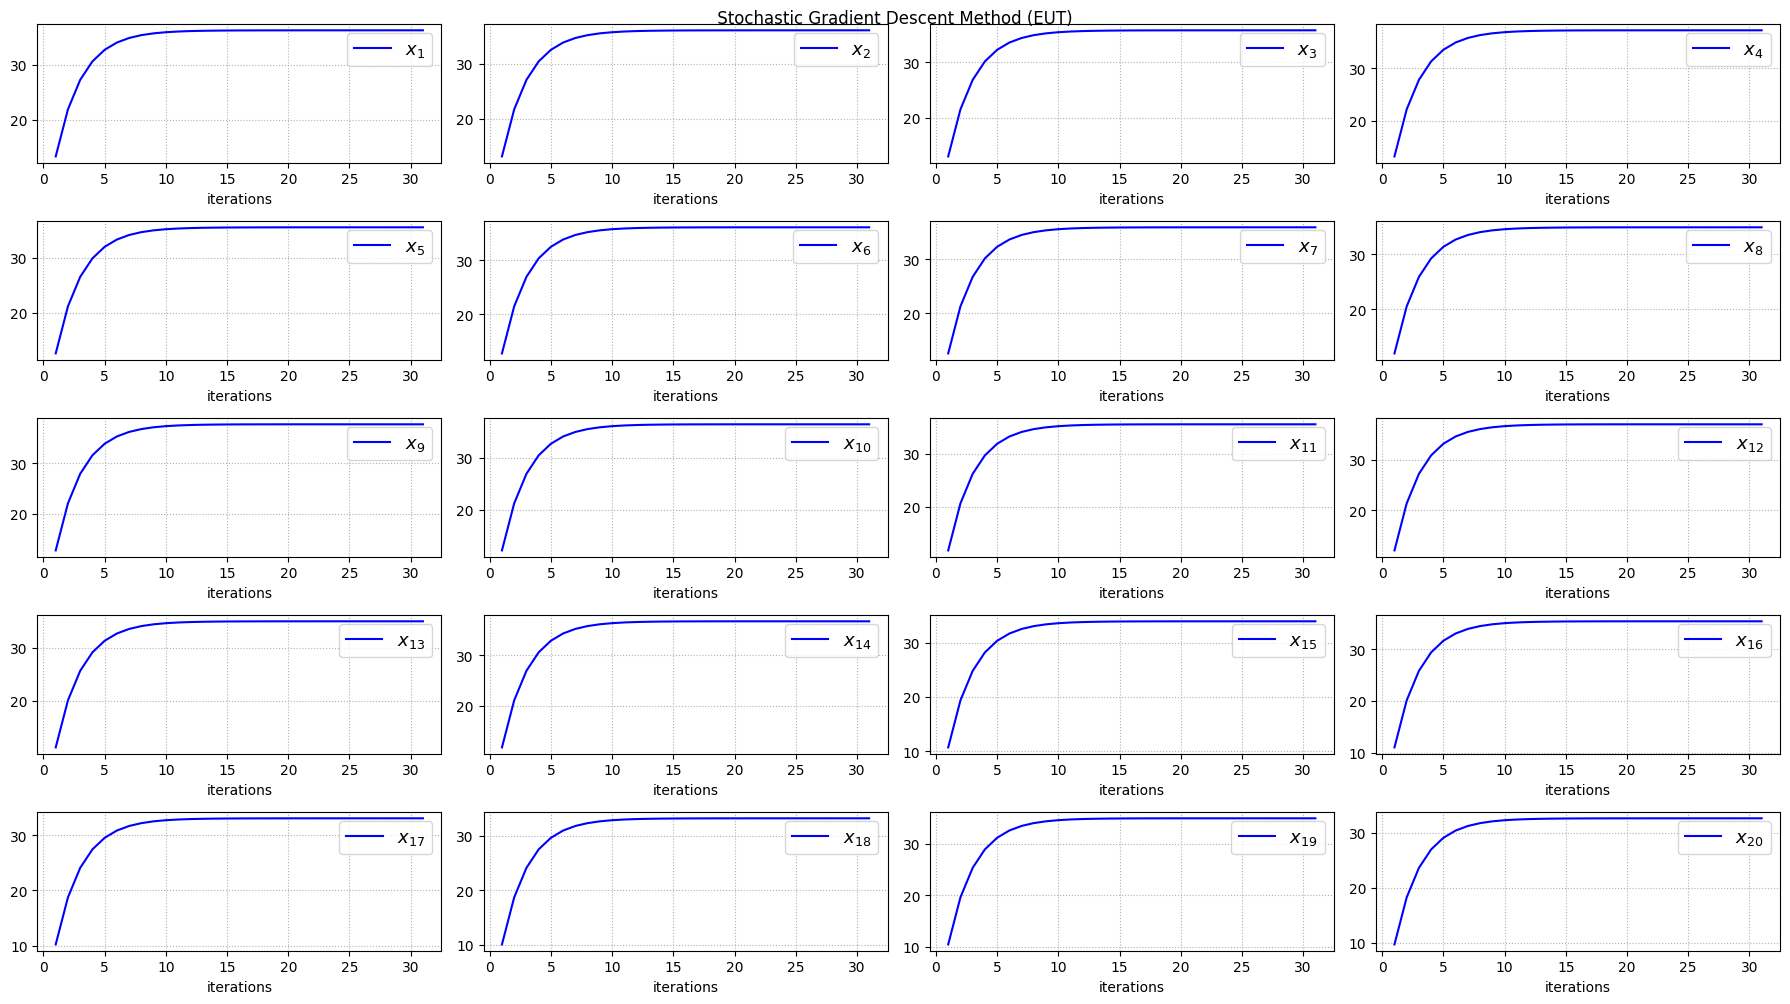

In [6]:
# graphique
iterations = np.arange(len(all_sol_eut)) + 1
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8) , (ax9, ax10, ax11, ax12),
      (ax13, ax14, ax15, ax16), (ax17, ax18, ax19, ax20)) = plt.subplots(nrows=5, ncols=4, figsize=(18, 10))
#------------------------------------------------------------#
ax1.plot(iterations, all_sol_eut[:, 0], color='blue', label=r'$x_1$')
ax1.legend(loc=0, fontsize=13)
ax1.grid(linestyle=':', linewidth=0.8)
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel('iterations')
#
ax2.plot(iterations, all_sol_eut[:, 1], color='blue', label=r'$x_2$')
ax2.legend(loc=0, fontsize=13)
ax2.grid(linestyle=':', linewidth=0.8)
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel('iterations')
#
ax3.plot(iterations, all_sol_eut[:, 2], color='blue', label=r'$x_3$')
ax3.legend(loc=0, fontsize=13)
ax3.xaxis.get_major_locator().set_params(integer=True)
ax3.grid(linestyle=':', linewidth=0.8)
ax3.set_xlabel('iterations')
#
ax4.plot(iterations, all_sol_eut[:, 3], color='blue', label=r'$x_4$')
ax4.legend(loc=0, fontsize=13)
ax4.grid(linestyle=':', linewidth=0.8)
ax4.xaxis.get_major_locator().set_params(integer=True)
ax4.set_xlabel('iterations')
#------------------------------------------------------------#
ax5.plot(iterations, all_sol_eut[:, 4], color='blue', label=r'$x_5$')
ax5.legend(loc=0, fontsize=13)
ax5.grid(linestyle=':', linewidth=0.8)
ax6.xaxis.get_major_locator().set_params(integer=True)
ax5.set_xlabel('iterations')
#
ax6.plot(iterations, all_sol_eut[:, 5], color='blue', label=r'$x_6$')
ax6.legend(loc=0, fontsize=13)
ax6.grid(linestyle=':', linewidth=0.8)
ax6.xaxis.get_major_locator().set_params(integer=True)
ax6.set_xlabel('iterations')
#
ax7.plot(iterations, all_sol_eut[:, 6], color='blue', label=r'$x_7$')
ax7.legend(loc=0, fontsize=13)
ax7.xaxis.get_major_locator().set_params(integer=True)
ax7.grid(linestyle=':', linewidth=0.8)
ax7.set_xlabel('iterations')
#
ax8.plot(iterations, all_sol_eut[:, 7], color='blue', label=r'$x_8$')
ax8.legend(loc=0, fontsize=13)
ax8.grid(linestyle=':', linewidth=0.8)
ax8.xaxis.get_major_locator().set_params(integer=True)
ax8.set_xlabel('iterations')
#------------------------------------------------------------#
ax9.plot(iterations, all_sol_eut[:, 8], color='blue', label=r'$x_9$')
ax9.legend(loc=0, fontsize=13)
ax9.grid(linestyle=':', linewidth=0.8)
ax9.xaxis.get_major_locator().set_params(integer=True)
ax9.set_xlabel('iterations')
#
ax10.plot(iterations, all_sol_eut[:, 9], color='blue', label=r'$x_{10}$')
ax10.legend(loc=0, fontsize=13)
ax10.grid(linestyle=':', linewidth=0.8)
ax10.xaxis.get_major_locator().set_params(integer=True)
ax10.set_xlabel('iterations')
#
ax11.plot(iterations, all_sol_eut[:, 10], color='blue', label=r'$x_{11}$')
ax11.legend(loc=0, fontsize=13)
ax11.xaxis.get_major_locator().set_params(integer=True)
ax11.grid(linestyle=':', linewidth=0.8)
ax11.set_xlabel('iterations')
#
ax12.plot(iterations, all_sol_eut[:, 11], color='blue', label=r'$x_{12}$')
ax12.legend(loc=0, fontsize=13)
ax12.grid(linestyle=':', linewidth=0.8)
ax12.xaxis.get_major_locator().set_params(integer=True)
ax12.set_xlabel('iterations')
#------------------------------------------------------------#
ax13.plot(iterations, all_sol_eut[:, 12], color='blue', label=r'$x_{13}$')
ax13.legend(loc=0, fontsize=13)
ax13.grid(linestyle=':', linewidth=0.8)
ax13.xaxis.get_major_locator().set_params(integer=True)
ax13.set_xlabel('iterations')
#
ax14.plot(iterations, all_sol_eut[:, 13], color='blue', label=r'$x_{14}$')
ax14.legend(loc=0, fontsize=13)
ax14.grid(linestyle=':', linewidth=0.8)
ax14.xaxis.get_major_locator().set_params(integer=True)
ax14.set_xlabel('iterations')
#
ax15.plot(iterations, all_sol_eut[:, 14], color='blue', label=r'$x_{15}$')
ax15.legend(loc=0, fontsize=13)
ax15.xaxis.get_major_locator().set_params(integer=True)
ax15.grid(linestyle=':', linewidth=0.8)
ax15.set_xlabel('iterations')
#
ax16.plot(iterations, all_sol_eut[:, 15], color='blue', label=r'$x_{16}$')
ax16.legend(loc=0, fontsize=13)
ax16.grid(linestyle=':', linewidth=0.8)
ax16.xaxis.get_major_locator().set_params(integer=True)
ax16.set_xlabel('iterations')
#------------------------------------------------------------#
ax17.plot(iterations, all_sol_eut[:, 16], color='blue', label=r'$x_{17}$')
ax17.legend(loc=0, fontsize=13)
ax17.grid(linestyle=':', linewidth=0.8)
ax17.xaxis.get_major_locator().set_params(integer=True)
ax17.set_xlabel('iterations')
#
ax18.plot(iterations, all_sol_eut[:, 17], color='blue', label=r'$x_{18}$')
ax18.legend(loc=0, fontsize=13)
ax18.grid(linestyle=':', linewidth=0.8)
ax18.xaxis.get_major_locator().set_params(integer=True)
ax18.set_xlabel('iterations')
#
ax19.plot(iterations, all_sol_eut[:, 18], color='blue', label=r'$x_{19}$')
ax19.legend(loc=0, fontsize=13)
ax19.xaxis.get_major_locator().set_params(integer=True)
ax19.grid(linestyle=':', linewidth=0.8)
ax19.set_xlabel('iterations')
#
ax20.plot(iterations, all_sol_eut[:, 19], color='blue', label=r'$x_{20}$')
ax20.legend(loc=0, fontsize=13)
ax20.grid(linestyle=':', linewidth=0.8)
ax20.xaxis.get_major_locator().set_params(integer=True)
ax20.set_xlabel('iterations')
#------------------------------------------------------------#
plt.tight_layout()
fig.suptitle(' Stochastic Gradient Descent Method (EUT) ', y=1.0)
plt.show()

In [7]:
# Solution EUT
sol_eut = torch.tensor(all_sol_eut[-1])
# fi_eut
fi_eut = [obj_fun_eut(i=i, x=sol_eut[i] ,x_i=sol_eut, xi_val=xi_v).item() for i in range(n)]

## CPT

In [8]:
# weighting function
def Tversky_Kahneman_prob(p, delta):
    return (p ** delta)/((p ** delta) + (1 - p) ** delta)**(1 / delta)


p_val = np.sort(np.linspace(start=0.45, stop=0.95, num=500))
#p_val =  np.sort(np.random.uniform(low=0.4, high=0.95, size=500))
gamma_loss_aver = 0.9#0.9
k_loss_aver =  np.array([2.407, 2.465, 2.591, 2.630, 2.757, 2.775, 2.778, 2.827, 2.985, 3.046, 3.077, 3.128,
                         3.351, 3.450, 3.554, 3.587, 3.669, 3.683, 3.719, 3.791])
alpha_loss_aver = 0.1246#0.235
beta_loss_aver = 0.33983#0.3358
w_p1_loss_aver = Tversky_Kahneman_prob(p=p_val, delta=gamma_loss_aver)
#------------------------------------------------------------------------------------------------#
gamma_aggresive = 0.7 #0.7 #0.6999
k_aggresive = np.array([0.143, 0.153, 0.155, 0.160, 0.174, 0.196, 0.217, 0.263, 0.288, 0.319, 0.325, 0.328,
                        0.337, 0.344, 0.346, 0.348, 0.365, 0.373, 0.375, 0.382])
alpha_aggresive = 1.20 # 1.008
beta_aggresive = 1.0352 #0.503
w_p1_aggresive = Tversky_Kahneman_prob(p=p_val, delta=gamma_aggresive)
#------------------------------------------------------------------------------------------------#

In [9]:
# objective_function CPT
def obj_fun_cpt(i:int, x, x_i, w1, k, alpha_v, beta_v, P_OH_val=P_OH_v, b_val=b_v, xi_val=xi_v, y=y_v, x0=x_0, a=a_v, b=bi_v):
    # params
    Ref = 0
    k_params = k[i]
    w2 = 1 - w1
    #----------------#
    N = len(x_i)
    a_i = a[i]
    b_i = b[i]
    y_i = y[i]
    mu_xi = torch.mean(xi_val)
    indices = [j for j in range(N) if j != i]
    x_neg_i = x_i[indices]
    sn = torch.sum(x_neg_i)
    U_i = - a_i * ((x + sn) / N - x0) ** 2 + b_i
    C_i = P_OH_val * x + P_PH(xi=mu_xi, P_OH=P_OH_val, b=b_val) * (y_i - x)
    #C_i = P_OH_val * x + P_PH(xi=xi_val, P_OH=P_OH_val, b=b_val) * (y_i - x)
    f_i = U_i - C_i
    #----------------#
    #return torch.sum(-k_params * torch.tensor(w2, dtype=torch.float32) * ((Ref - f_i) ** beta_v))
    if f_i >= Ref:
        return torch.sum(torch.tensor(w1, dtype=torch.float32) * ((f_i - Ref) ** alpha_v))
    else:
        return torch.sum(-k_params * torch.tensor(w2, dtype=torch.float32) * ((Ref - f_i) ** beta_v))
    #----------------#

# optim_cpt
def optim_cpt(N_agents:int, w1, k_val, alpha_val, beta_val):
    # optim params
    num_iterations = 300
    tolerance = 1e-6
    learning_rate_0 = 10e-2
    #
    x_values = np.array((num_iterations + 1) * [np.repeat(a=np.nan, repeats=N_agents)])
    for iteration in range(num_iterations + 1):
        learning_rate = learning_rate_0 / (iteration + 1)
        if iteration == 0:
            x_values[iteration, :] = np.repeat(a=1., repeats=N_agents)
        for i in range(N_agents):
            if iteration == 0:
                x_i_copy = torch.tensor(x_values[iteration, i].item(), requires_grad=True)
                loss = obj_fun_cpt(i=i,x=x_i_copy, x_i=torch.tensor(x_values[iteration, :]), w1=w1, k=k_val, alpha_v=alpha_val, beta_v=beta_val)
                loss.backward()
                x_new = projection(x_values[iteration, i].item() + learning_rate * x_i_copy.grad)
                x_values[iteration, i] = x_new
            else:
                x_i_copy = torch.tensor(x_values[iteration - 1, i].item(), requires_grad=True)
                loss = obj_fun_cpt(i=i, x=x_i_copy, x_i=torch.tensor(x_values[iteration-1, :]), w1=w1, k=k_val,
                                   alpha_v=alpha_val, beta_v=beta_val)
                loss.backward()
                x_new = projection(x_values[iteration - 1, i].item() + learning_rate * x_i_copy.grad)
                x_values[iteration, i] = x_new
    #
    res = x_values
    return res


### Loss aversion

In [10]:
# execution CPT loss aversion
all_sol_cpt_loss_aver = optim_cpt(N_agents=n, w1=w_p1_loss_aver, k_val=k_loss_aver,
                                  alpha_val=alpha_loss_aver, beta_val=beta_loss_aver)
sol_cpt_loss_aver_clean = torch.tensor(all_sol_cpt_loss_aver[-1])
fi_cpt_loss_aver = [obj_fun_eut(i=i, x=sol_cpt_loss_aver_clean[i] ,x_i=sol_cpt_loss_aver_clean, xi_val=xi_v).item() for i in range(n)]

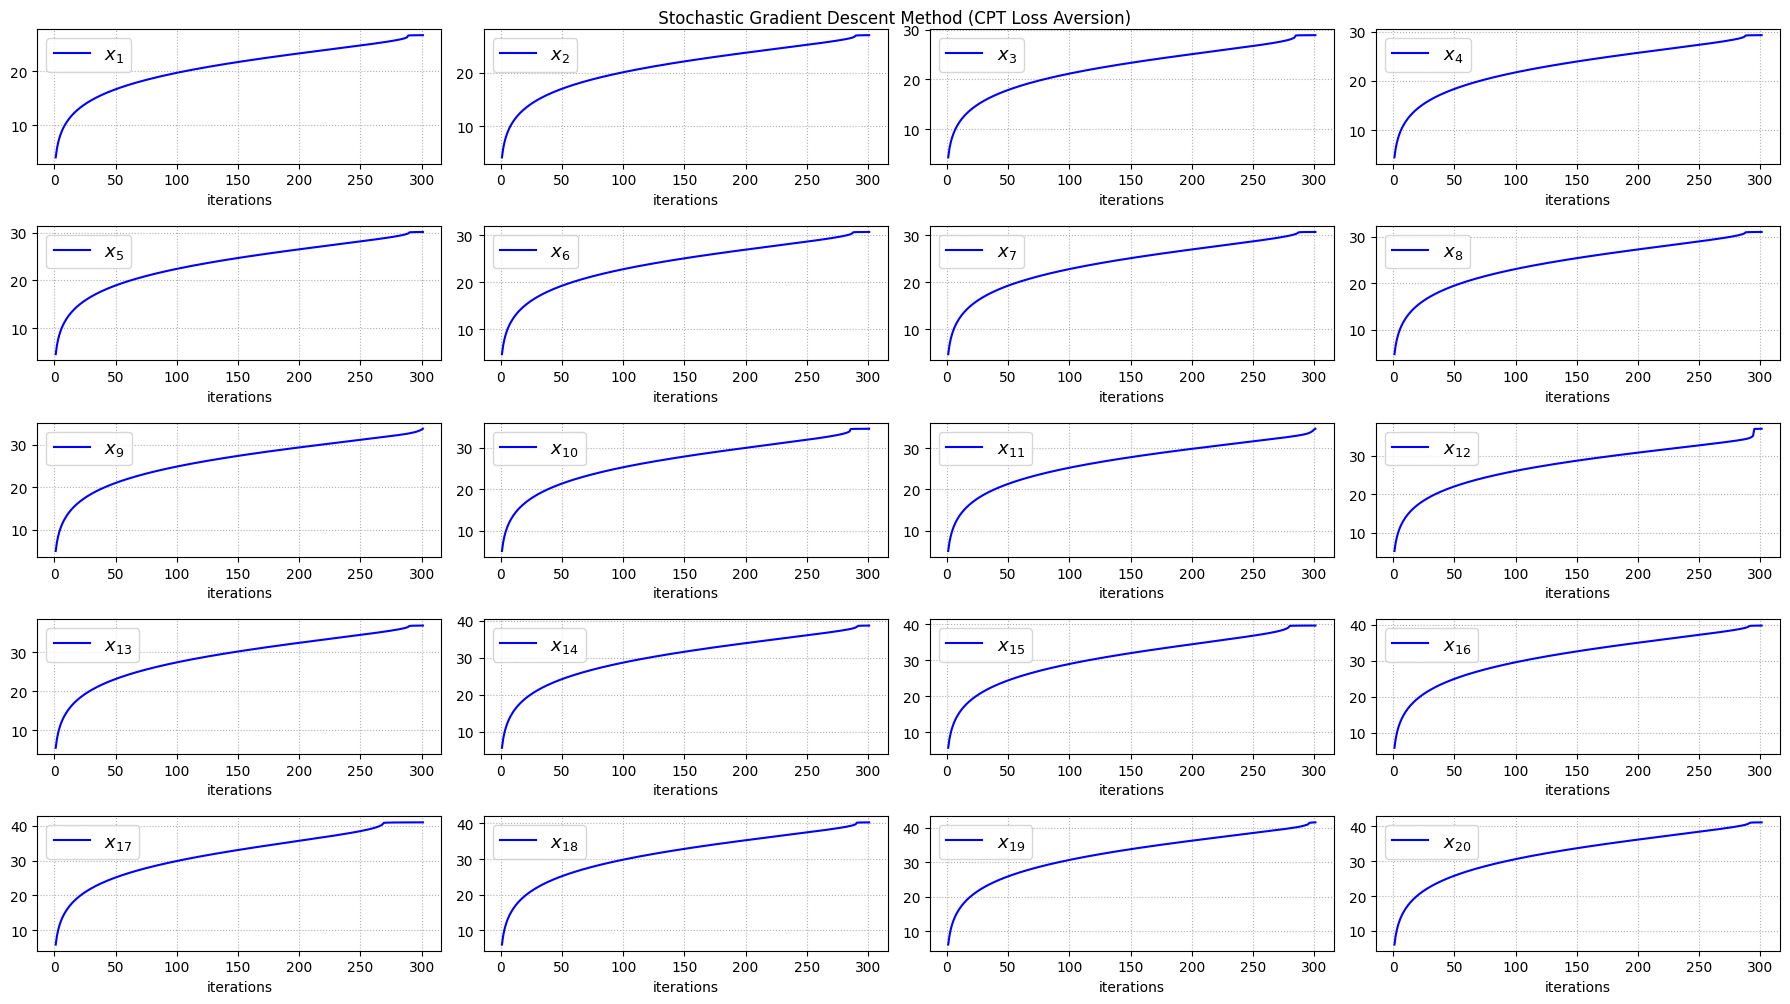

In [11]:
# graphique
iterations = np.arange(len(all_sol_cpt_loss_aver)) + 1
fig, ((bx1, bx2, bx3, bx4), (bx5, bx6, bx7, bx8) , (bx9, bx10, bx11, bx12),
      (bx13, bx14, bx15, bx16), (bx17, bx18, bx19, bx20)) = plt.subplots(nrows=5, ncols=4, figsize=(18, 10))
#------------------------------------------------------------#
bx1.plot(iterations, all_sol_cpt_loss_aver[:, 0], color='blue', label=r'$x_1$')
bx1.legend(loc=0, fontsize=13)
bx1.grid(linestyle=':', linewidth=0.8)
bx1.xaxis.get_major_locator().set_params(integer=True)
bx1.set_xlabel('iterations')
#
bx2.plot(iterations, all_sol_cpt_loss_aver[:, 1], color='blue', label=r'$x_2$')
bx2.legend(loc=0, fontsize=13)
bx2.grid(linestyle=':', linewidth=0.8)
bx2.xaxis.get_major_locator().set_params(integer=True)
bx2.set_xlabel('iterations')
#
bx3.plot(iterations, all_sol_cpt_loss_aver[:, 2], color='blue', label=r'$x_3$')
bx3.legend(loc=0, fontsize=13)
bx3.xaxis.get_major_locator().set_params(integer=True)
bx3.grid(linestyle=':', linewidth=0.8)
bx3.set_xlabel('iterations')
#
bx4.plot(iterations, all_sol_cpt_loss_aver[:, 3], color='blue', label=r'$x_4$')
bx4.legend(loc=0, fontsize=13)
bx4.grid(linestyle=':', linewidth=0.8)
bx4.xaxis.get_major_locator().set_params(integer=True)
bx4.set_xlabel('iterations')
#------------------------------------------------------------#
bx5.plot(iterations, all_sol_cpt_loss_aver[:, 4], color='blue', label=r'$x_5$')
bx5.legend(loc=0, fontsize=13)
bx5.grid(linestyle=':', linewidth=0.8)
bx6.xaxis.get_major_locator().set_params(integer=True)
bx5.set_xlabel('iterations')
#
bx6.plot(iterations, all_sol_cpt_loss_aver[:, 5], color='blue', label=r'$x_6$')
bx6.legend(loc=0, fontsize=13)
bx6.grid(linestyle=':', linewidth=0.8)
bx6.xaxis.get_major_locator().set_params(integer=True)
bx6.set_xlabel('iterations')
#
bx7.plot(iterations, all_sol_cpt_loss_aver[:, 6], color='blue', label=r'$x_7$')
bx7.legend(loc=0, fontsize=13)
bx7.xaxis.get_major_locator().set_params(integer=True)
bx7.grid(linestyle=':', linewidth=0.8)
bx7.set_xlabel('iterations')
#
bx8.plot(iterations, all_sol_cpt_loss_aver[:, 7], color='blue', label=r'$x_8$')
bx8.legend(loc=0, fontsize=13)
bx8.grid(linestyle=':', linewidth=0.8)
bx8.xaxis.get_major_locator().set_params(integer=True)
bx8.set_xlabel('iterations')
#------------------------------------------------------------#
bx9.plot(iterations, all_sol_cpt_loss_aver[:, 8], color='blue', label=r'$x_9$')
bx9.legend(loc=0, fontsize=13)
bx9.grid(linestyle=':', linewidth=0.8)
bx9.xaxis.get_major_locator().set_params(integer=True)
bx9.set_xlabel('iterations')
#
bx10.plot(iterations, all_sol_cpt_loss_aver[:, 9], color='blue', label=r'$x_{10}$')
bx10.legend(loc=0, fontsize=13)
bx10.grid(linestyle=':', linewidth=0.8)
bx10.xaxis.get_major_locator().set_params(integer=True)
bx10.set_xlabel('iterations')
#
bx11.plot(iterations, all_sol_cpt_loss_aver[:, 10], color='blue', label=r'$x_{11}$')
bx11.legend(loc=0, fontsize=13)
bx11.xaxis.get_major_locator().set_params(integer=True)
bx11.grid(linestyle=':', linewidth=0.8)
bx11.set_xlabel('iterations')
#
bx12.plot(iterations, all_sol_cpt_loss_aver[:, 11], color='blue', label=r'$x_{12}$')
bx12.legend(loc=0, fontsize=13)
bx12.grid(linestyle=':', linewidth=0.8)
bx12.xaxis.get_major_locator().set_params(integer=True)
bx12.set_xlabel('iterations')
#------------------------------------------------------------#
bx13.plot(iterations, all_sol_cpt_loss_aver[:, 12], color='blue', label=r'$x_{13}$')
bx13.legend(loc=0, fontsize=13)
bx13.grid(linestyle=':', linewidth=0.8)
bx13.xaxis.get_major_locator().set_params(integer=True)
bx13.set_xlabel('iterations')
#
bx14.plot(iterations, all_sol_cpt_loss_aver[:, 13], color='blue', label=r'$x_{14}$')
bx14.legend(loc=0, fontsize=13)
bx14.grid(linestyle=':', linewidth=0.8)
bx14.xaxis.get_major_locator().set_params(integer=True)
bx14.set_xlabel('iterations')
#
bx15.plot(iterations, all_sol_cpt_loss_aver[:, 14], color='blue', label=r'$x_{15}$')
bx15.legend(loc=0, fontsize=13)
bx15.xaxis.get_major_locator().set_params(integer=True)
bx15.grid(linestyle=':', linewidth=0.8)
bx15.set_xlabel('iterations')
#
bx16.plot(iterations, all_sol_cpt_loss_aver[:, 15], color='blue', label=r'$x_{16}$')
bx16.legend(loc=0, fontsize=13)
bx16.grid(linestyle=':', linewidth=0.8)
bx16.xaxis.get_major_locator().set_params(integer=True)
bx16.set_xlabel('iterations')
#------------------------------------------------------------#
bx17.plot(iterations, all_sol_cpt_loss_aver[:, 16], color='blue', label=r'$x_{17}$')
bx17.legend(loc=0, fontsize=13)
bx17.grid(linestyle=':', linewidth=0.8)
bx17.xaxis.get_major_locator().set_params(integer=True)
bx17.set_xlabel('iterations')
#
bx18.plot(iterations, all_sol_cpt_loss_aver[:, 17], color='blue', label=r'$x_{18}$')
bx18.legend(loc=0, fontsize=13)
bx18.grid(linestyle=':', linewidth=0.8)
bx18.xaxis.get_major_locator().set_params(integer=True)
bx18.set_xlabel('iterations')
#
bx19.plot(iterations, all_sol_cpt_loss_aver[:, 18], color='blue', label=r'$x_{19}$')
bx19.legend(loc=0, fontsize=13)
bx19.xaxis.get_major_locator().set_params(integer=True)
bx19.grid(linestyle=':', linewidth=0.8)
bx19.set_xlabel('iterations')
#
bx20.plot(iterations, all_sol_cpt_loss_aver[:, 19], color='blue', label=r'$x_{20}$')
bx20.legend(loc=0, fontsize=13)
bx20.grid(linestyle=':', linewidth=0.8)
bx20.xaxis.get_major_locator().set_params(integer=True)
bx20.set_xlabel('iterations')
#------------------------------------------------------------#
plt.tight_layout()
fig.suptitle(' Stochastic Gradient Descent Method (CPT Loss Aversion) ', y=1.0)
plt.show()

### Aggressive

In [12]:
# execution CPT aggressive
all_sol_cpt_aggresive = optim_cpt(N_agents=n, w1=w_p1_aggresive, k_val=k_aggresive,
                                  alpha_val=alpha_aggresive, beta_val=beta_aggresive)
sol_cpt_aggresive_clean = torch.tensor(all_sol_cpt_aggresive[-1])
fi_cpt_aggresive = [obj_fun_eut(i=i, x=sol_cpt_aggresive_clean[i] ,x_i=sol_cpt_aggresive_clean, xi_val=xi_v).item() for i in range(n)]

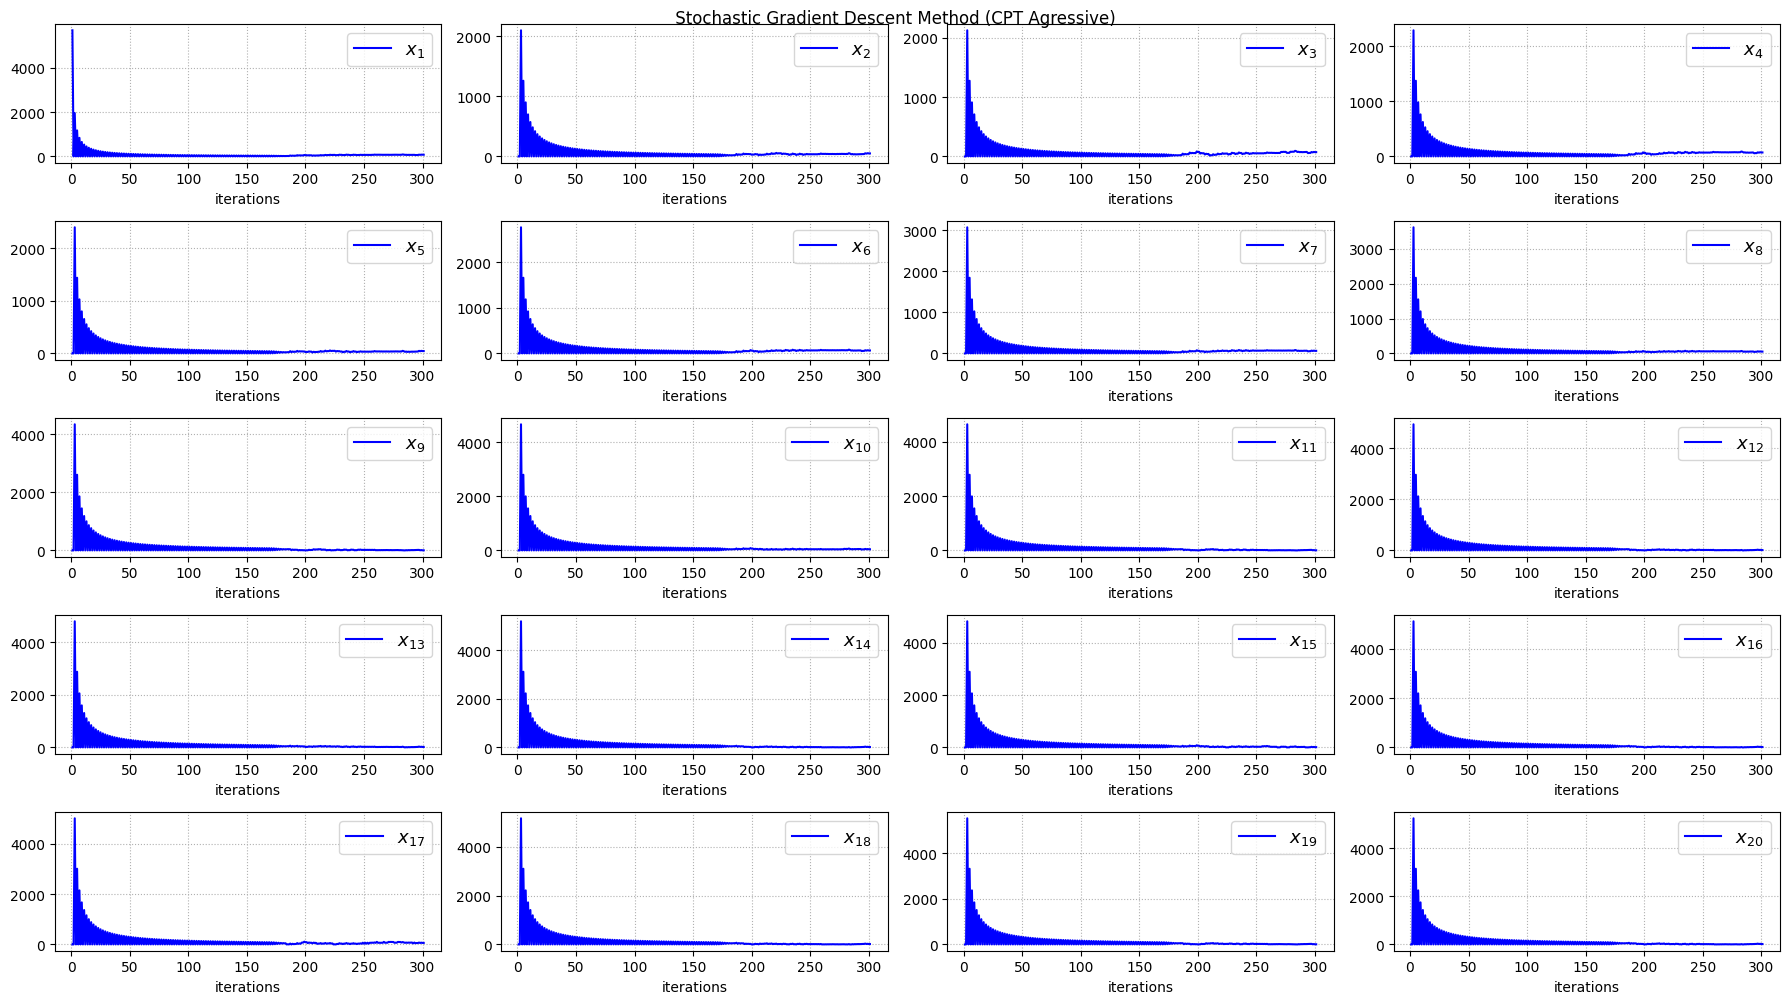

In [13]:
# graphique
iterations = np.arange(len(all_sol_cpt_aggresive)) + 1
fig, ((cx1, cx2, cx3, cx4), (cx5, cx6, cx7, cx8) , (cx9, cx10, cx11, cx12),
      (cx13, cx14, cx15, cx16), (cx17, cx18, cx19, cx20)) = plt.subplots(nrows=5, ncols=4, figsize=(18, 10))
#------------------------------------------------------------#
cx1.plot(iterations, all_sol_cpt_aggresive[:, 0], color='blue', label=r'$x_1$')
cx1.legend(loc=0, fontsize=13)
cx1.grid(linestyle=':', linewidth=0.8)
cx1.xaxis.get_major_locator().set_params(integer=True)
cx1.set_xlabel('iterations')
#
cx2.plot(iterations, all_sol_cpt_aggresive[:, 1], color='blue', label=r'$x_2$')
cx2.legend(loc=0, fontsize=13)
cx2.grid(linestyle=':', linewidth=0.8)
cx2.xaxis.get_major_locator().set_params(integer=True)
cx2.set_xlabel('iterations')
#
cx3.plot(iterations, all_sol_cpt_aggresive[:, 2], color='blue', label=r'$x_3$')
cx3.legend(loc=0, fontsize=13)
cx3.xaxis.get_major_locator().set_params(integer=True)
cx3.grid(linestyle=':', linewidth=0.8)
cx3.set_xlabel('iterations')
#
cx4.plot(iterations, all_sol_cpt_aggresive[:, 3], color='blue', label=r'$x_4$')
cx4.legend(loc=0, fontsize=13)
cx4.grid(linestyle=':', linewidth=0.8)
cx4.xaxis.get_major_locator().set_params(integer=True)
cx4.set_xlabel('iterations')
#------------------------------------------------------------#
cx5.plot(iterations, all_sol_cpt_aggresive[:, 4], color='blue', label=r'$x_5$')
cx5.legend(loc=0, fontsize=13)
cx5.grid(linestyle=':', linewidth=0.8)
cx6.xaxis.get_major_locator().set_params(integer=True)
cx5.set_xlabel('iterations')
#
cx6.plot(iterations, all_sol_cpt_aggresive[:, 5], color='blue', label=r'$x_6$')
cx6.legend(loc=0, fontsize=13)
cx6.grid(linestyle=':', linewidth=0.8)
cx6.xaxis.get_major_locator().set_params(integer=True)
cx6.set_xlabel('iterations')
#
cx7.plot(iterations, all_sol_cpt_aggresive[:, 6], color='blue', label=r'$x_7$')
cx7.legend(loc=0, fontsize=13)
cx7.xaxis.get_major_locator().set_params(integer=True)
cx7.grid(linestyle=':', linewidth=0.8)
cx7.set_xlabel('iterations')
#
cx8.plot(iterations, all_sol_cpt_aggresive[:, 7], color='blue', label=r'$x_8$')
cx8.legend(loc=0, fontsize=13)
cx8.grid(linestyle=':', linewidth=0.8)
cx8.xaxis.get_major_locator().set_params(integer=True)
cx8.set_xlabel('iterations')
#------------------------------------------------------------#
cx9.plot(iterations, all_sol_cpt_aggresive[:, 8], color='blue', label=r'$x_9$')
cx9.legend(loc=0, fontsize=13)
cx9.grid(linestyle=':', linewidth=0.8)
cx9.xaxis.get_major_locator().set_params(integer=True)
cx9.set_xlabel('iterations')
#
cx10.plot(iterations, all_sol_cpt_aggresive[:, 9], color='blue', label=r'$x_{10}$')
cx10.legend(loc=0, fontsize=13)
cx10.grid(linestyle=':', linewidth=0.8)
cx10.xaxis.get_major_locator().set_params(integer=True)
cx10.set_xlabel('iterations')
#
cx11.plot(iterations, all_sol_cpt_aggresive[:, 10], color='blue', label=r'$x_{11}$')
cx11.legend(loc=0, fontsize=13)
cx11.xaxis.get_major_locator().set_params(integer=True)
cx11.grid(linestyle=':', linewidth=0.8)
cx11.set_xlabel('iterations')
#
cx12.plot(iterations, all_sol_cpt_aggresive[:, 11], color='blue', label=r'$x_{12}$')
cx12.legend(loc=0, fontsize=13)
cx12.grid(linestyle=':', linewidth=0.8)
cx12.xaxis.get_major_locator().set_params(integer=True)
cx12.set_xlabel('iterations')
#------------------------------------------------------------#
cx13.plot(iterations, all_sol_cpt_aggresive[:, 12], color='blue', label=r'$x_{13}$')
cx13.legend(loc=0, fontsize=13)
cx13.grid(linestyle=':', linewidth=0.8)
cx13.xaxis.get_major_locator().set_params(integer=True)
cx13.set_xlabel('iterations')
#
cx14.plot(iterations, all_sol_cpt_aggresive[:, 13], color='blue', label=r'$x_{14}$')
cx14.legend(loc=0, fontsize=13)
cx14.grid(linestyle=':', linewidth=0.8)
cx14.xaxis.get_major_locator().set_params(integer=True)
cx14.set_xlabel('iterations')
#
cx15.plot(iterations, all_sol_cpt_aggresive[:, 14], color='blue', label=r'$x_{15}$')
cx15.legend(loc=0, fontsize=13)
cx15.xaxis.get_major_locator().set_params(integer=True)
cx15.grid(linestyle=':', linewidth=0.8)
cx15.set_xlabel('iterations')
#
cx16.plot(iterations, all_sol_cpt_aggresive[:, 15], color='blue', label=r'$x_{16}$')
cx16.legend(loc=0, fontsize=13)
cx16.grid(linestyle=':', linewidth=0.8)
cx16.xaxis.get_major_locator().set_params(integer=True)
cx16.set_xlabel('iterations')
#------------------------------------------------------------#
cx17.plot(iterations, all_sol_cpt_aggresive[:, 16], color='blue', label=r'$x_{17}$')
cx17.legend(loc=0, fontsize=13)
cx17.grid(linestyle=':', linewidth=0.8)
cx17.xaxis.get_major_locator().set_params(integer=True)
cx17.set_xlabel('iterations')
#
cx18.plot(iterations, all_sol_cpt_aggresive[:, 17], color='blue', label=r'$x_{18}$')
cx18.legend(loc=0, fontsize=13)
cx18.grid(linestyle=':', linewidth=0.8)
cx18.xaxis.get_major_locator().set_params(integer=True)
cx18.set_xlabel('iterations')
#
cx19.plot(iterations, all_sol_cpt_aggresive[:, 18], color='blue', label=r'$x_{19}$')
cx19.legend(loc=0, fontsize=13)
cx19.xaxis.get_major_locator().set_params(integer=True)
cx19.grid(linestyle=':', linewidth=0.8)
cx19.set_xlabel('iterations')
#
cx20.plot(iterations, all_sol_cpt_aggresive[:, 19], color='blue', label=r'$x_{20}$')
cx20.legend(loc=0, fontsize=13)
cx20.grid(linestyle=':', linewidth=0.8)
cx20.xaxis.get_major_locator().set_params(integer=True)
cx20.set_xlabel('iterations')
#------------------------------------------------------------#
plt.tight_layout()
fig.suptitle(' Stochastic Gradient Descent Method (CPT Agressive) ', y=1.0)
plt.show()

## PoI

In [14]:
# PoI
profil_val = [round(sum(fi_cpt_aggresive)/sum(fi_eut),3), int(sum(fi_eut)/sum(fi_eut)), round(sum(fi_cpt_loss_aver)/sum(fi_eut),3)]

In [15]:
# heter_selection
def heter_selection1(a,b,c):
    ind_a = [6, 9, 2, 3, 5, 6, 7]
    ind_b = [5, 6, 7, 8, 9, 10]
    ind_c = [9, 10, 11, 12, 13, 14, 15]
    return [a[i] for i in ind_a] + [b[j] for j in ind_b] + [c[j] for j in ind_c]

def heter_selection2(a,b,c):
    ind_a = [5, 3, 6, 9, 2, 14, 16]
    ind_b = [ 8, 10, 18,  5,  3,  6,  9, 2, 14, 16]
    ind_c = [8, 10, 18]
    return [a[i] for i in ind_a] + [b[j] for j in ind_b] + [c[j] for j in ind_c]

def heter_selection3(a,b,c):
    ind_a = [8, 10, 18, 11, 12, 13, 15, 3, 14, 2]
    ind_b = [8, 10, 18, 11, 19, 17, 15]
    ind_c = [6, 14, 16]
    return [a[i] for i in ind_a] + [b[j] for j in ind_b] + [c[j] for j in ind_c]

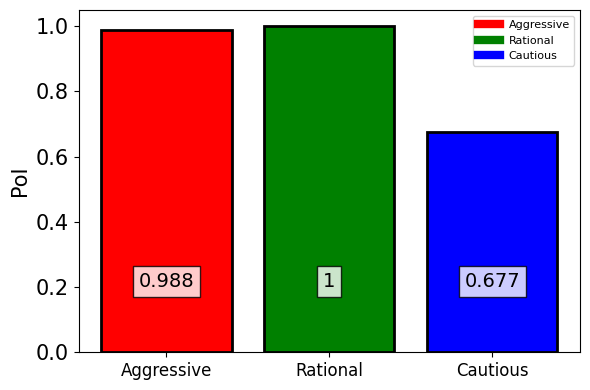

In [16]:
# Création du barplot
categories = ["Aggressive", "Rational", "Cautious"]
colors = ["red", "green", "blue"]
edge_colors = ["black", "black", "black"]

# Création du barplot
fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(categories, profil_val, color=colors, edgecolor=edge_colors, linewidth=2)
ax.set_ylabel('PoI', fontsize=15)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=15)
# Ajout des légendes personnalisées
legend_labels = [
    plt.Line2D([0], [0], color="red", lw=6, label="Aggressive"),
    plt.Line2D([0], [0], color="green", lw=6, label="Rational"),
    plt.Line2D([0], [0], color="blue", lw=6, label="Cautious")
]
ax.legend(handles=legend_labels, loc=0, fontsize=8)
for i in range(len(profil_val)):
    ax.text(i, 0.2, profil_val[i],fontsize=14, bbox=dict(facecolor='white', alpha=0.8), ha='center')
fig.tight_layout()
# Affichage
plt.show()


In [17]:
# PoI
# Heterogenous
# Heterogenous
fi_cpt_hetero1 = heter_selection1(fi_eut,fi_cpt_loss_aver,fi_cpt_aggresive)
fi_cpt_hetero2 = heter_selection2(fi_eut,fi_cpt_aggresive,fi_cpt_loss_aver)
fi_cpt_hetero3 = heter_selection3(fi_cpt_loss_aver,fi_eut,fi_cpt_aggresive)

In [18]:
# data
# PoI
values = ([round(sum(fi_cpt_hetero1)/sum(fi_eut),3)] + [round(sum(fi_cpt_hetero2)/sum(fi_eut),3)] +
          [round(sum(fi_cpt_hetero3)/sum(fi_eut),3)] +[profil_val[0]]  + [profil_val[1]] + [profil_val[2]] )

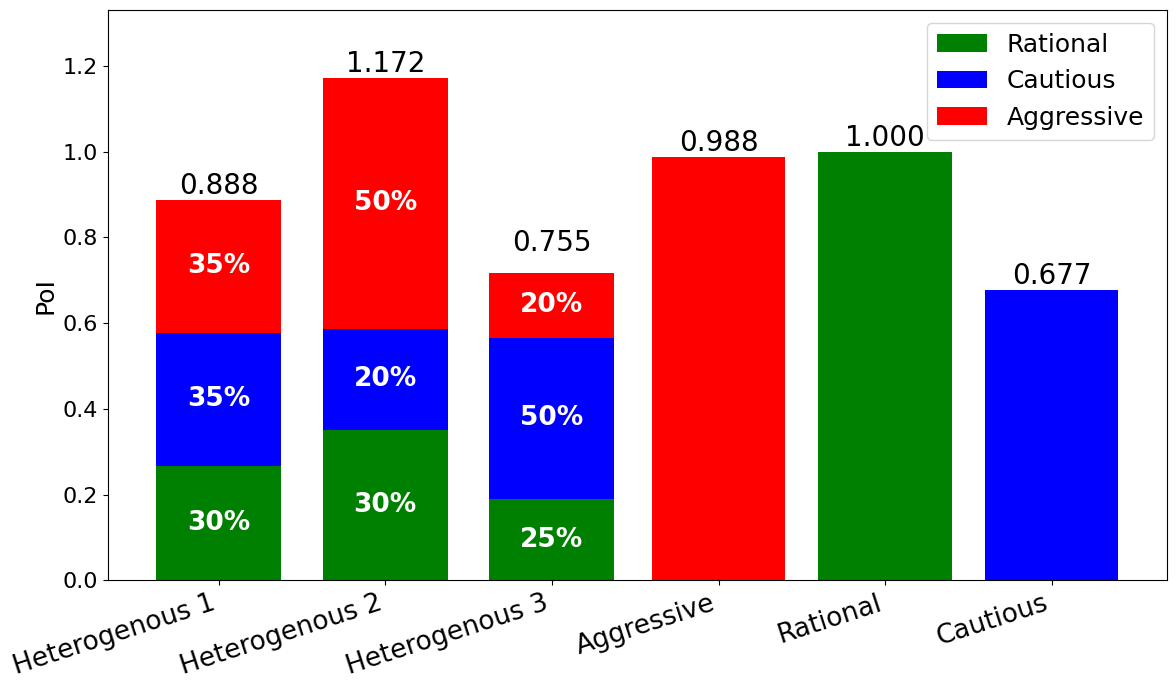

In [19]:
# data
categories = ["Heterogenous 1", "Heterogenous 2", "Heterogenous 3", "Aggressive", "Rational", "Cautious"]
colors = {"Rational": "green", "Cautious": "blue", "Aggressive": "red"}
hetero_1_composition = {"Rational": 0.30, "Cautious": 0.35, "Aggressive": 0.35}
hetero_2_composition = {"Rational": 0.30, "Cautious": 0.20, "Aggressive": 0.50}
hetero_3_composition = {"Rational": 0.25, "Cautious": 0.50, "Aggressive": 0.20}


# Création du graphique
fig, ax = plt.subplots(figsize=(12, 7))
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
# Initialisation de la légende pour éviter les doublons
legend_added = set()
# Fonction pour dessiner une barre hétérogène segmentée
def draw_heterogeneous_bar(x, total_value, composition):
    bottom = 0  # Pour empiler les segments
    for label, percent in composition.items():
        segment_height = total_value * percent
        if label not in legend_added:
            ax.bar(x, segment_height, width=0.75, bottom=bottom, color=colors[label], label=label)
            legend_added.add(label)
        else:
            ax.bar(x, segment_height, width=0.75, bottom=bottom, color=colors[label])

        # Ajouter le % au centre du segment
        ax.text(x, bottom + segment_height / 2, f"{percent * 100:.0f}%", ha='center', va='center', fontsize=19,
                color='white', fontweight='bold')
        bottom += segment_height  # Mise à jour du bas pour le prochain segment
# Dessiner les barres hétérogènes
draw_heterogeneous_bar(0, values[0], hetero_1_composition)  # Heterogeneous 1
draw_heterogeneous_bar(1, values[1], hetero_2_composition)  # Heterogeneous 2
draw_heterogeneous_bar(2, values[2], hetero_3_composition)  # Heterogeneous 3

# Tracer les barres standard (Aggressive, Rational, Cautious)
for i, cat in enumerate(categories[3:]):  # On commence à l'index 3 pour ignorer les hétérogènes
    if cat not in legend_added:
        ax.bar(i + 3, values[i + 3], color=colors[cat], label=cat)  # Décalage des indices
        legend_added.add(cat)
    else:
        ax.bar(i + 3, values[i + 3], color=colors[cat])
# Ajouter les valeurs sur les barres
for i, v in enumerate(values):
    ax.text(i, v, f'{v:.3f}', ha='center', va='bottom', fontsize=20)
# Paramètres de l'axe
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=18, ha='right')  #
ax.set_ylabel('PoI', fontsize=18)
ax.set_ylim(0, 1.33)
#ax.set_ylim(0, 1.3)
ax.tick_params(axis='x', labelsize=19)
ax.tick_params(axis='y', labelsize=16)
#ax.legend(loc=4, fontsize=18)
ax.legend(loc=0, fontsize=18)
fig.tight_layout()
# Afficher le graphique
plt.show()


### Convergence